# How to use PyTorch LSTMs/GRUs for time series regression
We aim to forcast stock price value by using LSTM with Pytorch.

credit: https://github.com/CrosstabKite/lstm-forecasting/blob/master/lstm_forecasting.ipynb

modified on (12/02/2023)

# Data

In [1]:
!pip install torchinfo

In [2]:
!wget https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv

--2024-04-18 05:57:51--  https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv [following]
--2024-04-18 05:57:51--  https://raw.githubusercontent.com/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284248 (278K) [text/plain]
Saving to: ‘GOOG.csv’

GOOG.csv            100%[===================>] 277.59K  --.-KB/s    in 0.01s   

2024-04-18 05

In [3]:
import pandas as pd

df = pd.read_csv('GOOG.csv', index_col="Date")
df = df.drop(['Adj Close'], axis = 1)
df

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,44871300
2004-08-20,50.316402,54.336334,50.062355,53.952770,22942800
2004-08-23,55.168217,56.528118,54.321388,54.495735,18342800
2004-08-24,55.412300,55.591629,51.591621,52.239193,15319700
2004-08-25,52.284027,53.798351,51.746044,52.802086,9232100
...,...,...,...,...,...
2019-09-30,1220.969971,1226.000000,1212.300049,1219.000000,1404100
2019-10-01,1219.000000,1231.229980,1203.579956,1205.099976,1273500
2019-10-02,1196.979980,1196.979980,1171.290039,1176.630005,1615100


In [4]:
df.loc['2019-02-26']

Open      1.105750e+03
High      1.119510e+03
Low       1.099920e+03
Close     1.115130e+03
Volume    1.471300e+06
Name: 2019-02-26, dtype: float64

In [5]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig = px.line(df['Open'], labels=dict(
    created_at="Date", value="Open", variable="Sensor"
))
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

## Create the target variable

In [6]:
target_col = "Open"
features = list(df.columns.difference([target_col]))

forecast_lead = 1
target = f"{target_col}_lead{forecast_lead}"

df[target] = df[target_col].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

In [7]:
features

['Close', 'High', 'Low', 'Volume']

In [8]:
df

,Open,High,Low,Close,Volume,Open_lead1
Date,,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,44871300,50.316402
2004-08-20,50.316402,54.336334,50.062355,53.952770,22942800,55.168217
2004-08-23,55.168217,56.528118,54.321388,54.495735,18342800,55.412300
2004-08-24,55.412300,55.591629,51.591621,52.239193,15319700,52.284027
2004-08-25,52.284027,53.798351,51.746044,52.802086,9232100,52.279045
...,...,...,...,...,...,...
2019-09-27,1243.010010,1244.020020,1214.449951,1225.089966,1353900,1220.969971
2019-09-30,1220.969971,1226.000000,1212.300049,1219.000000,1404100,1219.000000
2019-10-01,1219.000000,1231.229980,1203.579956,1205.099976,1273500,1196.979980


## Create a hold-out test set and preprocess the data

In [9]:
test_start = "2019-01-01"
val_start = "2018-01-01"

df_train = df.loc[:val_start].copy()
df_val = df.loc[val_start:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.050157563025210086


## Standardize the features and target, based on the training set

In [10]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_val[c] = (df_val[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

## Create datasets that PyTorch `DataLoader` can work with

In [11]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [ ]:
i = 27
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.4005, -1.4044, -1.4018,  0.0794],
        [-1.4026, -1.4013, -1.3959,  0.1501],
        [-1.4059, -1.4081, -1.4001, -0.0974],
        [-1.3878, -1.3944, -1.3950,  1.0892]])


In [ ]:
X, y = train_dataset[i + 1]
print(X)

tensor([[-1.4026, -1.4013, -1.3959,  0.1501],
        [-1.4059, -1.4081, -1.4001, -0.0974],
        [-1.3878, -1.3944, -1.3950,  1.0892],
        [-1.3789, -1.3784, -1.3822,  2.7240]])


In [ ]:
print(df_train[features].iloc[(i - sequence_length + 1): (i + 1)])

               Close      High       Low    Volume
Date                                              
2004-09-23 -1.400509 -1.404409 -1.401750  0.079391
2004-09-24 -1.402597 -1.401323 -1.395935  0.150113
2004-09-27 -1.405909 -1.408082 -1.400095 -0.097414
2004-09-28 -1.387767 -1.394397 -1.394980  1.089247


In [12]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

NameError: name 'train_dataset' is not defined

## Create the datasets and data loaders for real

In this tutorial we will
use sequences of length 60 (60 days) to forcast 1 day ahead.

The PyTorch `DataLoader` is a very convenient way to iterate through these datasets. For
the training set we'll shuffle (the rows *within* each training sequence are not
shuffled, only the order in which we draw those blocks). For the test set, shuffling
isn't necessary.

In [ ]:
torch.manual_seed(101)

batch_size = 32
sequence_length = 60

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
val_dataset = SequenceDataset(
    df_val,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 60, 4])
Target shape: torch.Size([32])


In [ ]:
print(len(features))

4


# LSTM

## The model and learning algorithm

![picture](https://i.stack.imgur.com/SjnTl.png)

Credit : https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()
        self.num_features = num_features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 4

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        print("batch_size :",batch_size)
        # initialize the hidden and cell state of the LSTM layer
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).to(device).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[-1]).flatten()  # get the output of the last hidden layer
        return out


In [ ]:
learning_rate = 5e-4
num_hidden_units = 60

model = ShallowRegressionLSTM(num_features=len(features), hidden_units=num_hidden_units)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from torchinfo import summary
summary(model, input_size=(32, 60, 4))

batch_size : 32


Layer (type:depth-idx)                   Output Shape              Param #
ShallowRegressionLSTM                    [32]                      --
├─LSTM: 1-1                              [32, 60, 60]              103,680
├─Linear: 1-2                            [32, 1]                   61
Total params: 103,741
Trainable params: 103,741
Non-trainable params: 0
Total mult-adds (M): 199.07
Input size (MB): 0.03
Forward/backward pass size (MB): 0.92
Params size (MB): 0.41
Estimated Total Size (MB): 1.37

## Train

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    print( num_batches )
    total_loss = 0
    model.train()

    for X, y in data_loader:
        print(X.shape,y.shape)
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function, best_val_loss):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        torch.save(model.state_dict(), 'model.pth')
        print('Save new best model')
    return best_val_loss

In [ ]:
best_val_loss = torch.inf
for ix_epoch in tqdm(range(100)):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    best_val_loss = test_model(val_loader, model, loss_function, best_val_loss)
    print()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0
---------
106
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Size([32, 60, 4]) torch.Size([32])
batch_size : 32
torch.Siz

KeyboardInterrupt: 

## Evaluation

In [ ]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            y_star = model(X)
            output = torch.cat((output, y_star.detach().cpu()), 0)

    return output

In [ ]:
PATH = './model.pth'
model.load_state_dict(torch.load(PATH))

In [ ]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_val[ystar_col] = predict(val_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_val, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

In [ ]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print( 'MPAE =', MAPE(df_test['Open_lead1'], df_test['Model forecast']) )
print( 'RMSE =', math.sqrt(mean_squared_error(df_test['Open_lead1'], df_test['Model forecast'])) )

In [ ]:
fig = px.line(df_out, labels={'value': "Open", 'created_at': 'Date'})
fig.add_vline(x=val_start, line_width=4, line_dash="dash")
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
# fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

# GRU

## The model and learning algorithm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torch import nn

class ShallowRegressionGRU(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()
        self.num_features = num_features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 4

        self.gru = nn.GRU(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]

        # initialize the hidden and cell state of the LSTM layer
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).to(device).requires_grad_()

        _, hn = self.gru(x, h0)
        out = self.linear(hn[-1]).flatten()  # get the output of the last hidden layer
        return out


In [ ]:
learning_rate = 5e-4
num_hidden_units = 60

model = ShallowRegressionGRU(num_features=len(features), hidden_units=num_hidden_units)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from torchinfo import summary
summary(model, input_size=(32, 60, 4))

## Train

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function, best_val_loss):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        torch.save(model.state_dict(), 'model_gru.pth')
        print('Save new best model')
    return best_val_loss

In [ ]:
best_val_loss = torch.inf
for ix_epoch in tqdm(range(100)):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    best_val_loss = test_model(val_loader, model, loss_function, best_val_loss)
    print()

## Evaluation

In [ ]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            y_star = model(X)
            output = torch.cat((output, y_star.detach().cpu()), 0)

    return output

In [ ]:
PATH = './model_gru.pth'
model.load_state_dict(torch.load(PATH))

In [ ]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_val[ystar_col] = predict(val_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_val, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

In [ ]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print( 'MPAE =', MAPE(df_test['Open_lead1'], df_test['Model forecast']) )
print( 'RMSE =', math.sqrt(mean_squared_error(df_val['Open_lead1'], df_val['Model forecast'])) )

In [ ]:
fig = px.line(df_out, labels={'value': "Open", 'created_at': 'Date'})
fig.add_vline(x=val_start, line_width=4, line_dash="dash")
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
# fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

# ResNLS

**Data**


*   10 consecutive trading days as the unit step
*   clean


*   normalize it to eliminate scale differences
*   transform it into tensors

**Train** : closing price data of the SSE Composite
Index from January 1, 2011 to December 31, 2020

**Test** : closing price data from January 1, 2021 to December 31, 2021



**Conv**


*   filter = 64
*   kernel size = 3

*   applies ReLU as the activation
function
*   weight decay of 1e-5

**dropout layer** with a retain probability of 0.8

**LSTM**


*   hidden size = 32

**optimizer** Adam

batch size (64) with a larger initial
learning rate (1e-3) are preferred

epoch = 50



## Data

### AJ

In [127]:
val_start = "2007-01-01"
test_start = "2008-01-01"

df_train = df.loc[:val_start].copy()
df_val = df.loc[val_start:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.7773109243697479


## Other

In [144]:
import yfinance as yf

In [145]:
snp = yf.Ticker("^GSPC")

snp_hist = snp.history(start="2016-01-04", end="2022-05-26")

snp_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-04 00:00:00-05:00,2038.199951,2038.199951,1989.680054,2012.660034,4304880000,0.0,0.0
2016-01-05 00:00:00-05:00,2013.780029,2021.939941,2004.170044,2016.709961,3706620000,0.0,0.0
2016-01-06 00:00:00-05:00,2011.709961,2011.709961,1979.050049,1990.260010,4336660000,0.0,0.0
2016-01-07 00:00:00-05:00,1985.319946,1985.319946,1938.829956,1943.089966,5076590000,0.0,0.0
2016-01-08 00:00:00-05:00,1945.969971,1960.400024,1918.459961,1922.030029,4664940000,0.0,0.0
...,...,...,...,...,...,...,...
2022-05-19 00:00:00-04:00,3899.000000,3945.959961,3876.580078,3900.790039,5113550000,0.0,0.0
2022-05-20 00:00:00-04:00,3927.760010,3943.419922,3810.320068,3901.360107,5130730000,0.0,0.0
2022-05-23 00:00:00-04:00,3919.419922,3981.879883,3909.040039,3973.750000,4420030000,0.0,0.0


In [146]:
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig = px.line(snp_hist['Open'], labels=dict(
    created_at="Date", value="Open", variable="Sensor"
))
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

### Create the target variable

In [147]:
target_col = "Open"
features = list(snp_hist.columns.difference([target_col]))

forecast_lead = 1
target = f"{target_col}_lead{forecast_lead}"

snp_hist[target] = snp_hist[target_col].shift(-forecast_lead)
snp_hist = snp_hist.iloc[:-forecast_lead]

In [148]:
snp_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Open_lead1
Date,,,,,,,,
2016-01-04 00:00:00-05:00,2038.199951,2038.199951,1989.680054,2012.660034,4304880000,0.0,0.0,2013.780029
2016-01-05 00:00:00-05:00,2013.780029,2021.939941,2004.170044,2016.709961,3706620000,0.0,0.0,2011.709961
2016-01-06 00:00:00-05:00,2011.709961,2011.709961,1979.050049,1990.260010,4336660000,0.0,0.0,1985.319946
2016-01-07 00:00:00-05:00,1985.319946,1985.319946,1938.829956,1943.089966,5076590000,0.0,0.0,1945.969971
2016-01-08 00:00:00-05:00,1945.969971,1960.400024,1918.459961,1922.030029,4664940000,0.0,0.0,1926.119995
...,...,...,...,...,...,...,...,...
2022-05-18 00:00:00-04:00,4051.979980,4051.979980,3911.909912,3923.679932,5103220000,0.0,0.0,3899.000000
2022-05-19 00:00:00-04:00,3899.000000,3945.959961,3876.580078,3900.790039,5113550000,0.0,0.0,3927.760010
2022-05-20 00:00:00-04:00,3927.760010,3943.419922,3810.320068,3901.360107,5130730000,0.0,0.0,3919.419922


### Create a hold-out test set and preprocess the data

In [150]:
val_start = "2020-01-01"
test_start = "2021-01-01"

snp_hist_train = snp_hist.loc[:val_start].copy()
snp_hist_val = snp_hist.loc[val_start:test_start].copy()
snp_hist_test = snp_hist.loc[test_start:].copy()

print("Test set fraction:", len(snp_hist_test) / len(snp_hist))

Test set fraction: 0.21801242236024845


## Standardize the features and target, based on the training set

In [151]:
def prepData(df_train,df_val,df_test):
  target_mean = df_train[target].mean()
  target_stdev = df_train[target].std()

  for c in df_train.columns:
      mean = df_train[c].mean()
      stdev = df_train[c].std()

      df_train[c] = (df_train[c] - mean) / stdev
      df_val[c] = (df_val[c] - mean) / stdev
      df_test[c] = (df_test[c] - mean) / stdev
  return df_train,df_val,df_test

In [161]:
# df_train,df_val,df_test = prepData(df_train,df_val,df_test)

In [154]:
df_train,df_val,df_test= prepData(snp_hist_train,snp_hist_val,snp_hist_test)

In [163]:
features = ['Close', 'High', 'Low', 'Volume']

In [164]:
torch.manual_seed(101)
# aj
# batch_size = 32
# sequence_length = 60

# # best in paper
batch_size = 64
sequence_length = 5

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
val_dataset = SequenceDataset(
    df_val,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([64, 5, 4])
Target shape: torch.Size([64])


## The model and learning algorithm

In [165]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [166]:
from torch import nn
from torchinfo import summary

# input = (batch,10,4)
# output = (batch,10,4)
# filter of each conv = 64
# conv1 = (10) -> (64)
# conv2 = (64) -> (64)
# linear = (64) -> (10)
# shortcut = (10) -> (10)
class ResBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, filter, kernel_size=3, stride=1, padding=1):
        super(ResBlock, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels, filter, kernel_size, stride, padding)
        self.conv2 = torch.nn.Conv1d(filter, filter, kernel_size, stride, padding)
        self.linear = torch.nn.Linear(filter, out_channels)
        self.relu = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(filter, eps=1e-5)
        self.bn2 = torch.nn.BatchNorm1d(filter, eps=1e-5)
        self.dropout = nn.Dropout(0.2)
        # intialise weights of the attention mechanism
        self.weight = nn.Parameter(torch.zeros(1)).to(device)


    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn1(out)

        out = self.dropout(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.bn2(out)

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.weight*out
        out += x.view(x.size(0), -1)
        return out

# model = ResBlock(10, 10, 64)
# summary(model, input_size=(1, 10, 1))

In [167]:
class ResNLS(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_layer, num_layer, num_feature=4, filter=64, kernel_size=3):
        super(ResNLS, self).__init__()
        self.resblock1 = ResBlock(in_channels, in_channels, filter)
        self.resblock2 = ResBlock(in_channels, in_channels, filter)
        self.resblock3 = ResBlock(in_channels, in_channels, filter)
        self.resblock4 = ResBlock(in_channels, in_channels, filter)
        self.num_layers = num_layer
        self.hidden_layer = hidden_layer
        self.lstm = torch.nn.LSTM(num_feature, hidden_layer, num_layer, batch_first=True)
        self.linear = torch.nn.Linear(hidden_layer, out_channels)


    def forward(self, x):
        batch_size = x.size(0)
        out = torch.split(x, 1, 2)
        out1 = self.resblock1(out[0])
        out2 = self.resblock2(out[1])
        out3 = self.resblock3(out[2])
        out4 = self.resblock4(out[3])
        out1 = out1.unsqueeze(2)
        out2 = out2.unsqueeze(2)
        out3 = out3.unsqueeze(2)
        out4 = out4.unsqueeze(2)
        out = torch.cat((out1, out2, out3, out4), 2)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer).to(device).requires_grad_()
        _, (hn, _) = self.lstm(out, (h0, c0))
        out = self.linear(hn[-1]).flatten()
        return out

In [168]:
# Init from paper
num_consecutive_days = sequence_length
days_pred = 1
# num_lstm_hiddensize = 32
num_lstm_hiddensize = 64
# lstm_layers = 4 # from aj
# lstm_layers = 64 # from paper
lstm_layers = 1

num_features = len(features)
filters = 64  # Number of filters in convolutional layers
kernel_size = 3  # Kernel size for convolutional layers

model = ResNLS(num_consecutive_days,
               days_pred,
               num_lstm_hiddensize,
               lstm_layers,
               num_features,
               filters,
               kernel_size)
model.to(device)
summary(model, input_size=(batch_size, num_consecutive_days, num_features))

Layer (type:depth-idx)                   Output Shape              Param #
ResNLS                                   [64]                      --
├─ResBlock: 1-1                          [64, 5]                   --
│    └─Conv1d: 2-1                       [64, 64, 1]               1,024
│    └─ReLU: 2-2                         [64, 64, 1]               --
│    └─BatchNorm1d: 2-3                  [64, 64, 1]               128
│    └─Dropout: 2-4                      [64, 64, 1]               --
│    └─Conv1d: 2-5                       [64, 64, 1]               12,352
│    └─ReLU: 2-6                         [64, 64, 1]               --
│    └─BatchNorm1d: 2-7                  [64, 64, 1]               128
│    └─Linear: 2-8                       [64, 5]                   325
├─ResBlock: 1-2                          [64, 5]                   --
│    └─Conv1d: 2-9                       [64, 64, 1]               1,024
│    └─ReLU: 2-10                        [64, 64, 1]               --
│ 

In [169]:
parameters_to_decay = []
for name, param in model.named_parameters():
  if 'conv1' in name or 'conv2' in name:
        parameters_to_decay.append(param)

weight_decay=1e-5
learning_rate = 1e-3 # Optimizer lr
# optimizer = torch.optim.Adam([{'params': parameters_to_decay, 'weight_decay': weight_decay}], lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

loss_function = nn.MSELoss() # We use Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)

## Train

In [170]:
from tqdm.notebook import tqdm

def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function, best_val_loss):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        torch.save(model.state_dict(), 'model.pth')
        print('Save new best model')
    return best_val_loss , avg_loss

In [171]:
best_val_loss = torch.inf
train_losses = []
val_losses = []
for ix_epoch in tqdm(range(100)):
    print(f"Epoch {ix_epoch}\n---------")
    train_losses.append(train_model(train_loader, model, loss_function, optimizer=optimizer))
    best_val_loss,avg_loss = test_model(val_loader, model, loss_function, best_val_loss)
    val_losses.append(avg_loss)
    print()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0
---------
Train loss: 0.7701929099857807
Test loss: 3.303364098072052
Save new best model

Epoch 1
---------
Train loss: 0.2717148372903466
Test loss: 1.3015705347061157
Save new best model

Epoch 2
---------
Train loss: 0.03856120118871331
Test loss: 0.5351607352495193
Save new best model

Epoch 3
---------
Train loss: 0.01906542998040095
Test loss: 0.6245599500834942

Epoch 4
---------
Train loss: 0.01486744818976149
Test loss: 0.4644036032259464
Save new best model

Epoch 5
---------
Train loss: 0.01188057370018214
Test loss: 0.43188258819282055
Save new best model

Epoch 6
---------
Train loss: 0.009932331944582984
Test loss: 0.37120363488793373
Save new best model

Epoch 7
---------
Train loss: 0.008540687034837902
Test loss: 0.3203487377613783
Save new best model

Epoch 8
---------
Train loss: 0.007408768782624975
Test loss: 0.3069128096103668
Save new best model

Epoch 9
---------
Train loss: 0.006498719216324389
Test loss: 0.26474449411034584
Save new best model

Epoch 

## Eval

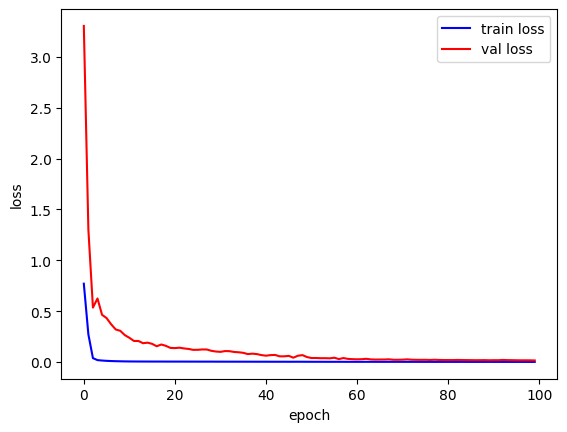

In [172]:
import matplotlib.pyplot as plt
def plotLosses(train_loss,val_loss):
  plt.plot(train_loss,color="blue",label="train loss")
  plt.plot(val_loss,color="red",label="val loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

plotLosses(train_losses,val_losses)

In [173]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            y_star = model(X)
            output = torch.cat((output, y_star.detach().cpu()), 0)

    return output

In [174]:
# PATH = './model_gru.pth'
# model.load_state_dict(torch.load(PATH))

In [175]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_val[ystar_col] = predict(val_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_val, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

                           Open_lead1  Model forecast
Date                                                 
2016-01-04 00:00:00-05:00   68.469740       68.554886
2016-01-05 00:00:00-05:00   68.129570       69.128769
2016-01-06 00:00:00-05:00   63.792951       66.769386
2016-01-07 00:00:00-05:00   57.326648       61.514679
2016-01-08 00:00:00-05:00   54.064741       57.284538
...                               ...             ...
2022-05-18 00:00:00-04:00  378.264191      360.625183
2022-05-19 00:00:00-04:00  382.990267      357.322174
2022-05-20 00:00:00-04:00  381.619757      354.584442
2022-05-23 00:00:00-04:00  385.484755      358.983948
2022-05-24 00:00:00-04:00  383.291000      357.416016

[1610 rows x 2 columns]


In [176]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
def MASE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y) / torch.mean(torch.abs(y[1:] - y[:-1]))))

def SMAPE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(200 * torch.mean(torch.abs(pred - y) / (torch.abs(y) + torch.abs(pred))))

def MAE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y)))

def sharp_ratio(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean((pred - y) / torch.std(y)))

print( 'MASE =', MASE(df_test['Open_lead1'], df_test['Model forecast']))
print( 'RMSE =', math.sqrt(mean_squared_error(df_test['Open_lead1'], df_test['Model forecast'])) )
print( 'SMAPE =', SMAPE(df_test['Open_lead1'], df_test['Model forecast']))
print( 'MAE =', MAE(df_test['Open_lead1'], df_test['Model forecast']))
print( 'sharp_ratio =', sharp_ratio(df_test['Open_lead1'], df_test['Model forecast']))

MASE = 49.451459009266344
RMSE = 1.379835808005246
SMAPE = 26.043058801889558
MAE = 1.254671385052784
sharp_ratio = 4.858520621651394


In [177]:
fig = px.line(df_out, labels={'value': "Open", 'created_at': 'Date'})
fig.add_vline(x=val_start, line_width=4, line_dash="dash")
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
# fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()